# Setting up ROMS grid file with TPXO-bathymetry

In [2]:
import pyresample
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import xarray as xr

from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

sys.path.append(os.environ.get('srcdir'))

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

from features.resample import resample
%aimport features.resample
from features.smooth_bathy import smoothing_PlusMinus_rx0
%aimport features.smooth_bathy
from features.uvp_masks import uvp_masks

ModuleNotFoundError: No module named 'features.resample'

In [2]:
tpxo_grid_path = os.path.join(os.environ.get('extdir'),'tpxo','grid_tpxo7.2.nc')
tpxo_grid = xr.open_dataset(tpxo_grid_path)
waom_path = his_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_data','waom10_grd.nc')
waom = xr.open_dataset(waom_path)

In [31]:
values = tpxo_grid.hz.values
lat_s = tpxo_grid.lat_z.values
lon_s = tpxo_grid.lon_z.values
lon_s[lon_s > 180] -= 360.0
print(lon_s.min(),lon_s.max())
tpxo_wct = np.asarray(resample(lon_s,lat_s,waom.lon_rho.values,waom.lat_rho.values,values))
tpxo_mask = np.asarray(resample(lon_s,lat_s,waom.lon_rho.values,waom.lat_rho.values,tpxo_grid.mz.values))

-179.75 180.0


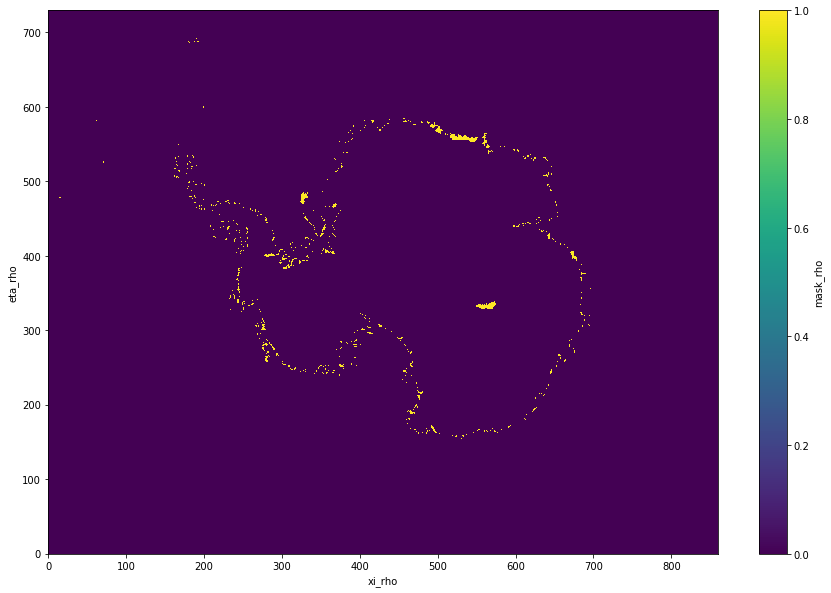

In [33]:
tpxo_mask[np.isnan(tpxo_mask)]=1
tpxo_mask[waom.mask_rho == 0] = 0
plt.close()
(waom.mask_rho-tpxo_mask).plot(size=10)
plt.show()

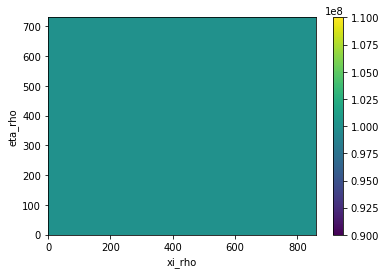

In [188]:
areas = 1.0/(waom.pn*waom.pm)
plt.close()
areas.plot()
plt.show()

In [190]:
#tpxo_wct_smooth = tpxo_wct.copy()
tpxo_wct_smooth, modifVal, ValueFct = smoothing_PlusMinus_rx0(tpxo_mask,tpxo_wct,0.3,areas.values)

     nbModif= 10992
     nbModif= 3844
     nbModif= 3282
     nbModif= 3181
     nbModif= 3148
     nbModif= 3132
     nbModif= 3123
     nbModif= 3112
     nbModif= 3107
     nbModif= 3099
     nbModif= 3073
     nbModif= 2949
     nbModif= 2540
     nbModif= 1856
     nbModif= 1390
     nbModif= 1322
     nbModif= 1316
     nbModif= 1309
     nbModif= 1292
     nbModif= 1280
     nbModif= 1250
     nbModif= 1201
     nbModif= 1087
     nbModif= 946
     nbModif= 791
     nbModif= 666
     nbModif= 630
     nbModif= 629
     nbModif= 629
     nbModif= 625
     nbModif= 620
     nbModif= 592
     nbModif= 561
     nbModif= 524
     nbModif= 449
     nbModif= 389
     nbModif= 352
     nbModif= 319
     nbModif= 313
     nbModif= 311
     nbModif= 308
     nbModif= 298
     nbModif= 294
     nbModif= 271
     nbModif= 266
     nbModif= 241
     nbModif= 222
     nbModif= 189
     nbModif= 161
     nbModif= 144
     nbModif= 137
     nbModif= 119
     nbModif= 119
     nbModif= 117
    

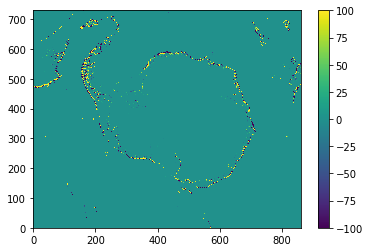

In [198]:
plt.close()
plt.pcolormesh(tpxo_wct_smooth-tpxo_wct,vmin=-100,vmax=100)
plt.colorbar()
plt.show()

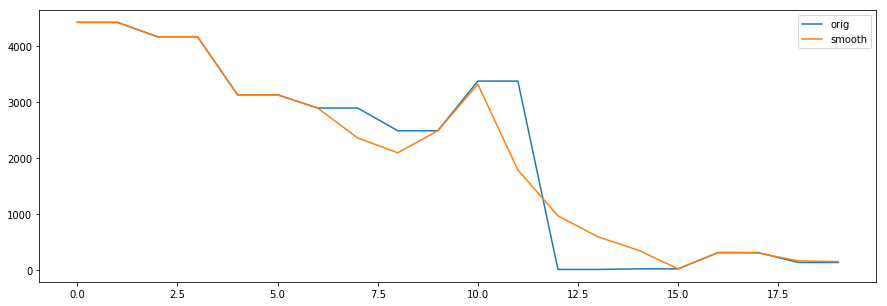

In [200]:
plt.close()
fig,ax = plt.subplots(1,figsize=(15,5))
ax.plot(tpxo_wct[597,180:200],label='orig')
ax.plot(tpxo_wct_smooth[597,180:200],label='smooth')
plt.legend()
plt.show()

10.0
50.0


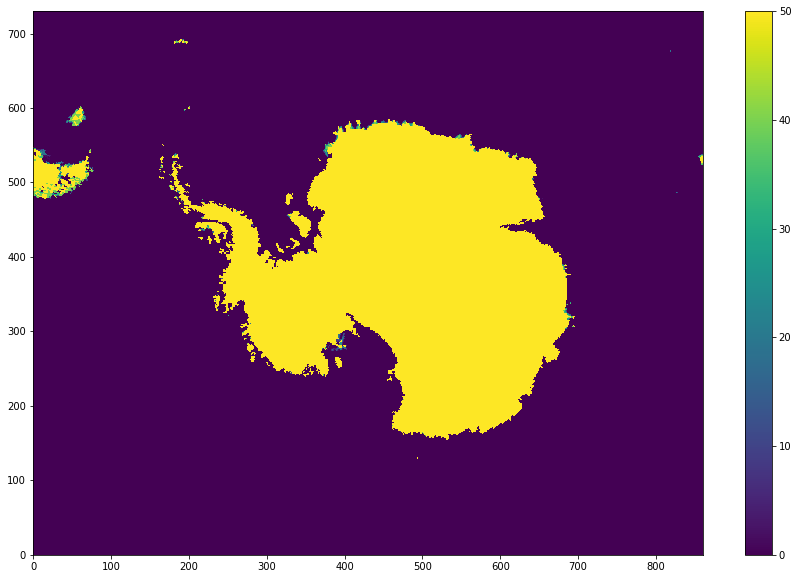

In [201]:
print(tpxo_wct_smooth[tpxo_mask==1].min())
tpxo_wct_smooth_deep = tpxo_wct_smooth.copy()
tpxo_wct_smooth_deep[tpxo_wct_smooth < 50] = 50.0
print(tpxo_wct_smooth_deep[tpxo_mask==1].min())
plt.close()
plt.figure(figsize=(15,10))
plt.pcolormesh(tpxo_wct_smooth_deep-tpxo_wct_smooth)
plt.colorbar()
plt.show()

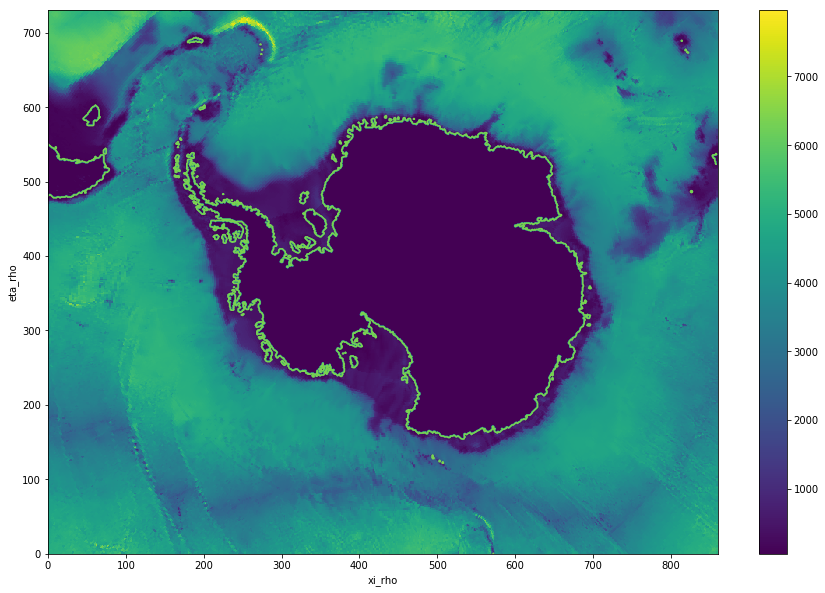

In [202]:
plt.close()
plt.figure(figsize=(15,10))
plt.pcolormesh(tpxo_wct_smooth_deep)
waom.mask_rho.plot.contour()
plt.colorbar()
plt.show()

In [203]:
waom.h.values = tpxo_wct_smooth_deep

mask_u,mask_v,mask_psi = uvp_masks(tpxo_mask)
waom.mask_rho.values = tpxo_mask
waom.mask_u.values = mask_u
waom.mask_v.values = mask_v
waom.mask_psi.values = mask_psi

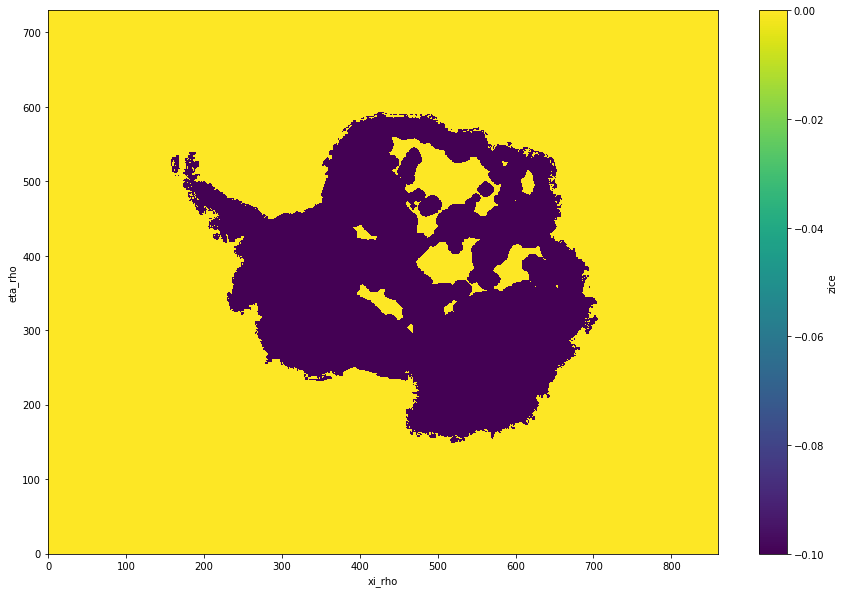

0.0 -0.1


In [204]:
waom.zice.values = waom.zice.where(waom.zice == 0.0,-0.1)
waom.zice[583:693,145:311] = 0.0
waom.zice[100:145,400:600] = 0.0
waom.zice[545:600,100:200] = 0.0
plt.close()
plt.figure(figsize=(15,10))
waom.zice.plot()
plt.show()
print(waom.zice.max().values,waom.zice.min().values)

In [205]:
out_file = os.path.join(waom_path,os.pardir,'waom10_grd_tpxo.nc')
waom[['h','zice','mask_rho','mask_u','mask_v','mask_psi']].to_netcdf(out_file,'a')

# Compare tidal height to TPXO forcing and ATG database

In [7]:
import datetime
import xarray as xr
import numpy as np

from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

sys.path.append(os.environ.get('srcdir'))

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

%aimport features.compare_tide
from features.compare_tide import compare_tide

%aimport features.compare_atg
from features.compare_tide import *

%aimport features.grid_ttide
from features.grid_ttide import *



tpxo_path = os.path.join(os.environ.get('rawdir'),'waom10_SSHUV','waom10_tds.nc')
dsf = xr.open_mfdataset(tpxo_path)

def analyse_case(file_path,case_str):
    rds = xr.open_dataset(file_path).sel(ocean_time=slice('2007-1-15','2007-2-15'))
    compare_tide(rds.zeta,rds,datetime.datetime(2007,1,15),['M2','O1'],
             np.arange(0,109),50,dsf,case_str)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


tidal analysis at atg stations ...
stime =  2007-01-15 00:00:00  constits =  ['M2', 'O1'] stations =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108]


VBox(children=(HTML(value=''), IntProgress(value=0, max=109)))

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_tide.py:619: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:57: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:60: RuntimeWarning: invalid value encountered in greater
  I = snr > synth


No predictions with this SNR
tidal analysis on whole grid ...
setting up the new fields  ['amp', 'amp_err', 'phase', 'phase_err']  for  ['O1', 'M2']
applying t_tide to every  50 th cell ...


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating intermediate cells and mask land
write out ATG and TPXO comparison for constituent: 
M2 RMSD: amp = 0.29 m    phase = 68.14 deg   complex amp = 0.46 m


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


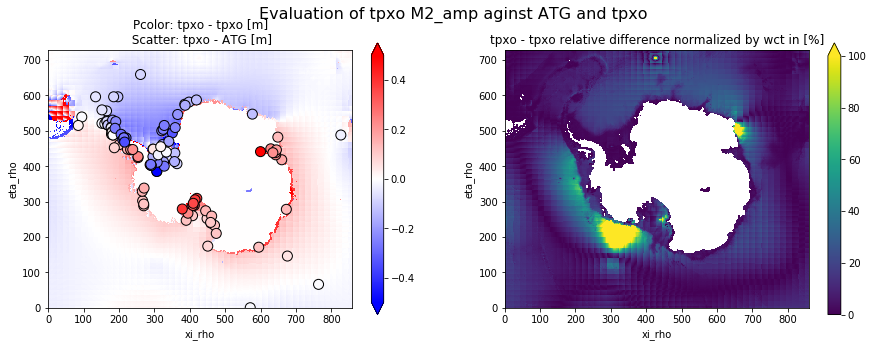

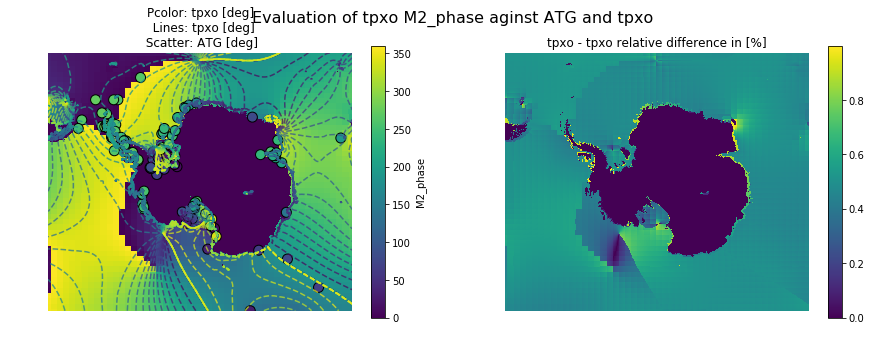

O1 RMSD: amp = 0.14 m    phase = 75.50 deg   complex amp = 0.23 m


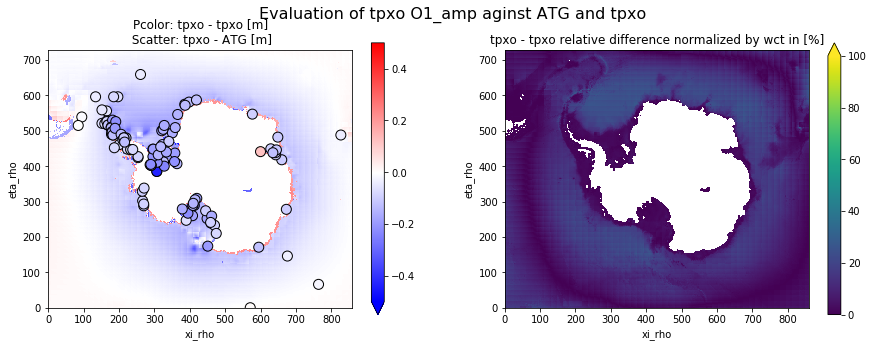

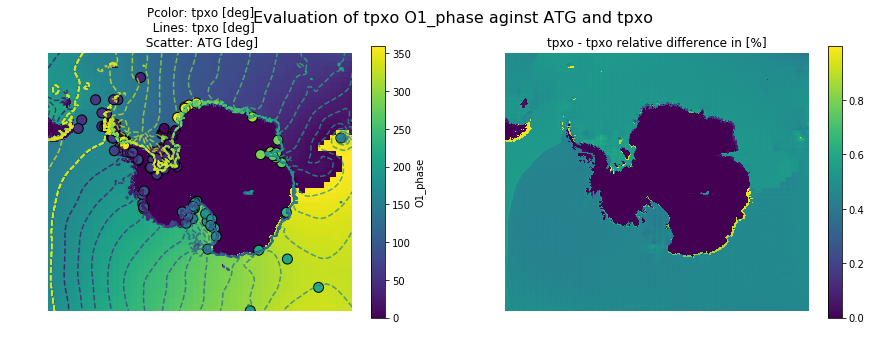

In [8]:
analyse_case(os.path.join(os.environ.get('rawdir'),'tpxo_flat_SSHUV','ocean_his.nc'),'tpxo')